In [1]:
import pandas as pd

# Read and clean data

In [2]:
df_tot = pd.read_csv (r'/Users/Jeaphianne/Documents/Work/MU/NanoSolveIT_proj_netw - projects.csv')
df_part = pd.read_csv (r'/Users/Jeaphianne/Documents/Work/MU/NanoSolveIT_proj_netw - partners.csv') 
df_fs = pd.read_csv (r'/Users/Jeaphianne/Documents/Work/MU/NanoSolveIT_proj_netw - fundingSchemas.csv') 

### Add identifiers to funding schemes

In [3]:
df_tot = df_tot.merge(df_fs, left_on='proj_fs', right_on='fs_name').drop(['fs_name'], axis=1)

### Add identifiers to partners

In [4]:
max_part = df_tot.proj_part.str.split(',').str.len().max()

part_cols = []
for i in range(max_part):
    part_cols.append("proj_part_"+str(i))
    
df_tot[part_cols] = df_tot.proj_part.str.split(",", expand=True)

In [5]:
max_p = df_part.part_name.str.split('|').str.len().max()

part_cols_2 = []
for i in range(max_p):
    part_cols_2.append("part_name_"+str(i))
    
df_part[part_cols_2] = df_part.part_name.str.split("|", expand=True)

In [6]:
ids = dict(zip(df_part['part_name_0'], df_part['part_id']))
ids

{'BAM': 'PART_00001',
 'BIOMAX': 'PART_00002',
 'HU': 'PART_00003',
 'Karolinska Institute': 'PART_00006',
 'LTU': 'PART_00004',
 'MISVIK': 'PART_00005',
 'NHLS': 'PART_00007',
 'NILU': 'PART_00008',
 'NRCWE': 'PART_00010',
 'NTUA': 'PART_00011',
 'NovaM': 'PART_00009',
 'QSARLab': 'PART_00012',
 'SU': 'PART_00014',
 'UCD': 'PART_00015',
 'UKRI': 'PART_00016',
 'UM': 'PART_00017',
 'UTA': 'PART_00019',
 'UTARTU': 'PART_00020',
 'Uni Gdansk': 'PART_00013',
 'UoB': 'PART_00018'}

In [7]:
for col in part_cols:
    df_tot[part_cols] = df_tot[part_cols].replace(ids, regex=True).fillna("")  

In [8]:
df_tot['proj_part_ids'] = df_tot[part_cols].agg(', '.join, axis=1).str.strip(", ")

In [9]:
df_tot=df_tot.drop(part_cols, 1)

In [10]:
df_tot=df_tot.sort_values(by='proj_id')

# Make RDF

In [ ]:
for i in range(df_tot.shape[0]):
    data = df_tot.iloc[i]
    print("epid:"+str(data['proj_id'])+" a epix:Project ;")
    print("    rdfs:label \""+str(data['proj_name'])+"\" ;")
    print("    epix:fundScheme epid:"+str(data['fs_id'])+" ;")
    print("    dct:date \""+str(data['y_s'])+"/"+str(data['y_e'])+"\"^^xsd:date ;")
    a = data['proj_part_ids'].split(", ")
    b = []
    for ids in a:
        b.append("epid:"+ids.strip())
    print("    dct:contributor "+", ".join(b)+" .")
    print()

In [ ]:
for i in range(df_tot.shape[0]):
    data = df_tot.iloc[i]
    print("epid:"+str(data['proj_id'])+" a epix:Project ; rdfs:label \""+str(data['proj_name'])+"\" .")

In [ ]:
for i in range(df_fs.shape[0]):
    data = df_fs.iloc[i]
    print("epid:"+str(data['fs_id'])+" a epix:fundScheme ; rdfs:label \""+str(data['fs_name'])+"\" .")

In [ ]:
for i in range(df_part.shape[0]):
    data = df_part.iloc[i]
    print("epid:"+str(data['part_id'])+" a dct:contributor ; rdfs:label \""+str(data['part_name_0'])+"\" .")

# Visualize

In [97]:
df_graph = df_tot[['proj_name', 'proj_part']]

In [98]:
#NB: Code from https://stackoverflow.com/questions/50731229/split-cell-into-multiple-rows-in-pandas-dataframe

import numpy as np
from itertools import chain

# return list from series of comma-separated strings
def chainer(s):
    return list(chain.from_iterable(s.str.split(',')))

# calculate lengths of splits
lens = df_graph['proj_part'].str.split(',').map(len)

# create new dataframe, repeating or chaining as appropriate
df_graph2 = pd.DataFrame({'proj_name': np.repeat(df_graph['proj_name'], lens),
                    'proj_part': chainer(df_graph['proj_part'])})

df_graph2['proj_part']=df_graph2['proj_part'].str.strip()

In [99]:
df_graph2['proj_coord'] = 'k'
df_graph2['proj_coord'][df_graph2['proj_part'].str.split(' \(').str.len()>1] = 'r'

In [100]:
df_graph2['proj_part']=df_graph2['proj_part'].str.split(' \(').str[0]

In [101]:
d = {'MISVIK through Karolinska Institute': 'Karolinska Institute', 'MISVIK through KI': 'Karolinska Institute', 'QSARLabs via Uni Gdansk': 'Uni Gdansk'}
for key in d:
    df_graph2['proj_part'] = df_graph2['proj_part'].str.replace(key, d[key])

In [102]:
import networkx as nx

G = nx.Graph()

In [103]:
G = nx.from_pandas_edgelist(df_graph2, 'proj_name', 'proj_part', create_using=nx.Graph() )

In [104]:
from matplotlib.pyplot import figure

In [113]:
colors = []

for node in G:
    if node in df_graph2['proj_part'].values:
        colors.append("c")
    else: colors.append("gold")

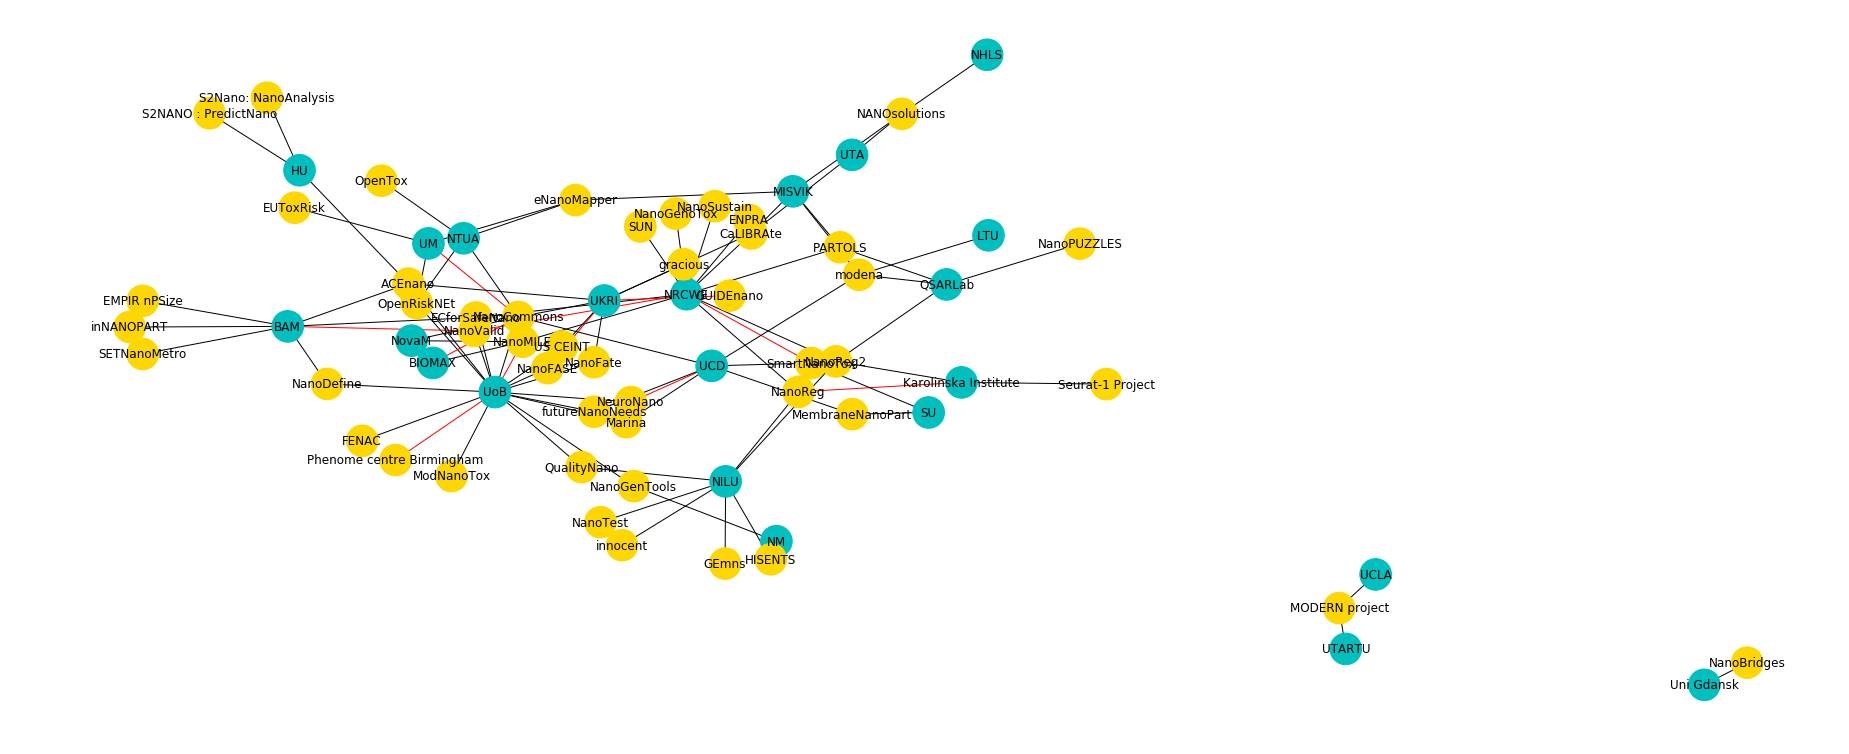

In [144]:
figure(figsize=(25, 10))
nx.draw_spring(G,k=0.3,iterations=30, with_labels=True, node_size=1000, node_color=colors, edge_color=df_graph2['proj_coord'])